# CY-EEW
What would system reporting times look like if an early warning system was set up to run with the Cyprus broadband network (CQ) with a network-based algorithm?

*Notebook by Savvas Marcou, PhD student at the Berkeley Seismology Lab (BSL) at the University of California, Berkeley (last update Feb 2023)*

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import geopandas as gpd
import subprocess
import os.path
import json
import gzip
import re
import warnings

import cartopy.crs as ccrs
import cartopy.feature as cft
import cartopy
import sys
sys.path.append("..")
sys.path.append("../..")

from obspy import UTCDateTime
from obspy.geodetics import gps2dist_azimuth
from obspy import read_inventory
from obspy.clients.fdsn import Client
from SeismoCode.utils import df_compiler, cua_envelope

from matplotlib.offsetbox import AnchoredText
from matplotlib.colors import LightSource
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import cm
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.colors import Normalize, LogNorm, TwoSlopeNorm
from matplotlib.dates import AutoDateFormatter, AutoDateLocator, date2num
import matplotlib.patheffects as path_effects

## Helpful plotting func

In [2]:
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='gray', alpha=0.5)
ocean_50m = cft.NaturalEarthFeature('physical', 'ocean', '50m',
                                    edgecolor='face',
                                    facecolor='skyblue', alpha=0.1)

In [3]:
# Scale bar functions from
# https://stackoverflow.com/questions/32333870/how-can-i-show-a-km-ruler-on-a-cartopy-matplotlib-plot/50674451#50674451
# Modified by CJ Chamberlain - GitHub https://github.com/calum-chamberlain/kaikoura-aftershocks
# /blob/master/Scripts/Analysis_Visualisation/kaikoura_csv_visualisations.py
def _axes_to_lonlat(ax, coords):
    """(lon, lat) from axes coordinates."""
    import cartopy.crs as ccrs

    display = ax.transAxes.transform(coords)
    data = ax.transData.inverted().transform(display)
    lonlat = ccrs.PlateCarree().transform_point(*data, ax.projection)

    return lonlat


def _upper_bound(start, direction, distance, dist_func):
    """A point farther than distance from start, in the given direction.
    It doesn't matter which coordinate system start is given in, as long
    as dist_func takes points in that coordinate system.
    Args:
        start:     Starting point for the line.
        direction  Nonzero (2, 1)-shaped array, a direction vector.
        distance:  Positive distance to go past.
        dist_func: A two-argument function which returns distance.
    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    if distance <= 0:
        raise ValueError(f"Minimum distance is not positive: {distance}")

    if np.linalg.norm(direction) == 0:
        raise ValueError("Direction vector must not be zero.")

    # Exponential search until the distance between start and end is
    # greater than the given limit.
    length = 0.1
    end = start + length * direction

    while dist_func(start, end) < distance:
        length *= 2
        end = start + length * direction

    return end


def _distance_along_line(start, end, distance, dist_func, tol):
    """Point at a distance from start on the segment  from start to end.
    It doesn't matter which coordinate system start is given in, as long
    as dist_func takes points in that coordinate system.
    Args:
        start:     Starting point for the line.
        end:       Outer bound on point's location.
        distance:  Positive distance to travel.
        dist_func: Two-argument function which returns distance.
        tol:       Relative error in distance to allow.
    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    initial_distance = dist_func(start, end)
    if initial_distance < distance:
        raise ValueError(f"End is closer to start ({initial_distance}) than "
                         f"given distance ({distance}).")

    if tol <= 0:
        raise ValueError(f"Tolerance is not positive: {tol}")

    # Binary search for a point at the given distance.
    left = start
    right = end

    while not np.isclose(dist_func(start, right), distance, rtol=tol):
        midpoint = (left + right) / 2

        # If midpoint is too close, search in second half.
        if dist_func(start, midpoint) < distance:
            left = midpoint
        # Otherwise the midpoint is too far, so search in first half.
        else:
            right = midpoint

    return right


def _point_along_line(ax, start, distance, angle=0, tol=0.01):
    """Point at a given distance from start at a given angle.
    Args:
        ax:       CartoPy axes.
        start:    Starting point for the line in axes coordinates.
        distance: Positive physical distance to travel.
        angle:    Anti-clockwise angle for the bar, in radians. Default: 0
        tol:      Relative error in distance to allow. Default: 0.01
    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    import cartopy.geodesic as cgeo
    # Direction vector of the line in axes coordinates.
    direction = np.array([np.cos(angle), np.sin(angle)])

    geodesic = cgeo.Geodesic()

    # Physical distance between points.
    def dist_func(a_axes, b_axes):
        a_phys = _axes_to_lonlat(ax, a_axes)
        b_phys = _axes_to_lonlat(ax, b_axes)

        # Geodesic().inverse returns a NumPy MemoryView like [[distance,
        # start azimuth, end azimuth]].
        #print(geodesic.inverse(a_phys, b_phys))
        # return geodesic.inverse(a_phys, b_phys).base[0, 0]
        return geodesic.inverse(a_phys, b_phys)[0][0]


    end = _upper_bound(start, direction, distance, dist_func)

    return _distance_along_line(start, end, distance, dist_func, tol)


def scale_bar(ax, location, length, metres_per_unit=1000, unit_name='km',
              tol=0.01, angle=0, color='black', linewidth=3, text_offset=0.005,
              ha='center', va='bottom', fontsize='medium', plot_kwargs=None, text_kwargs=None,
              **kwargs):
    """Add a scale bar to CartoPy axes.
    For angles between 0 and 90 the text and line may be plotted at
    slightly different angles for unknown reasons. To work around this,
    override the 'rotation' keyword argument with text_kwargs.
    Args:
        ax:              CartoPy axes.
        location:        Position of left-side of bar in axes coordinates.
        length:          Geodesic length of the scale bar.
        metres_per_unit: Number of metres in the given unit. Default: 1000
        unit_name:       Name of the given unit. Default: 'km'
        tol:             Allowed relative error in length of bar. Default: 0.01
        angle:           Anti-clockwise rotation of the bar.
        color:           Color of the bar and text. Default: 'black'
        linewidth:       Same argument as for plot.
        text_offset:     Perpendicular offset for text in axes coordinates.
                         Default: 0.005
        ha:              Horizontal alignment. Default: 'center'
        va:              Vertical alignment. Default: 'bottom'
        **plot_kwargs:   Keyword arguments for plot, overridden by **kwargs.
        **text_kwargs:   Keyword arguments for text, overridden by **kwargs.
        **kwargs:        Keyword arguments for both plot and text.
    """
    # Setup kwargs, update plot_kwargs and text_kwargs.
    if plot_kwargs is None:
        plot_kwargs = {}
    if text_kwargs is None:
        text_kwargs = {}

    plot_kwargs = {'linewidth': linewidth, 'color': color, **plot_kwargs,
                   **kwargs}
    text_kwargs = {'ha': ha, 'va': va, 'rotation': angle, 'color': color, 'size': fontsize,
                   **text_kwargs, **kwargs}

    # Convert all units and types.
    location = np.asarray(location)  # For vector addition.
    length_metres = length * metres_per_unit
    angle_rad = angle * np.pi / 180

    # End-point of bar.
    end = _point_along_line(ax, location, length_metres, angle=angle_rad,
                            tol=tol)

    # Coordinates are currently in axes coordinates, so use transAxes to
    # put into data coordinates. *zip(a, b) produces a list of x-coords,
    # then a list of y-coords.
    ax.plot(*zip(location, end), transform=ax.transAxes, **plot_kwargs)

    # Push text away from bar in the perpendicular direction.
    midpoint = (location + end) / 2
    offset = text_offset * np.array([-np.sin(angle_rad), np.cos(angle_rad)])
    text_location = midpoint + offset

    # 'rotation' keyword argument is in text_kwargs.
    ax.text(*text_location, f"{length} {unit_name}", rotation_mode='anchor',
            transform=ax.transAxes, **text_kwargs)


## Load data

In [4]:
# Read inventory of the Cypriot network
client = Client("NOA")

inv = client.get_stations(network="CQ", station="*")

In [5]:
# Extract inv to df
inv_df = df_compiler.create_stat_df(inv, save_data=False, outfile=None)

Network CQ contains 13 stations


In [6]:
inv_df

,net_code,code,lat,lon,elev,start,end
0,CQ,OSC1,33.5,31.2768,-2361.0,2014-01-16T00:00:00.000000Z,None
1,CQ,SUNI,34.755,32.882,512.0,2016-01-01T00:00:00.000000Z,2017-07-12T00:00:00.000000Z
2,CQ,APOL,34.671,32.863,150.0,2019-05-31T00:00:00.000000Z,None
3,CQ,NATA,34.7789,32.5699,381.0,2014-02-13T00:00:00.000000Z,None
4,CQ,ATHA,35.141,33.396,160.0,2014-02-13T00:00:00.000000Z,None
5,CQ,OSC2,33.0749,32.2669,-1560.0,2014-01-16T00:00:00.000000Z,None
6,CQ,ASGA,34.786,33.248,217.0,2014-02-13T00:00:00.000000Z,None
7,CQ,TROD,34.9472,32.8661,1855.0,2016-11-15T00:00:00.000000Z,None
8,CQ,PARA,34.994,34.04,116.0,2014-02-13T00:00:00.000000Z,None
9,CQ,AKMS,35.018,32.335,346.0,2014-02-13T00:00:00.000000Z,None


In [7]:
inv_df = inv_df[inv_df['end'].isin([None])]
inv_df.reset_index(drop=True, inplace=True)

In [8]:
inv_df['elev_km'] = inv_df['elev']/1000

/var/folders/_q/dj7ghxs92yz4nym0h3hw1mnh0000gn/T/ipykernel_3378/3633268535.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inv_df['elev_km'] = inv_df['elev']/1000


In [9]:
inv_df

,net_code,code,lat,lon,elev,start,end,elev_km
0,CQ,OSC1,33.5,31.2768,-2361.0,2014-01-16T00:00:00.000000Z,None,-2.361
1,CQ,APOL,34.671,32.863,150.0,2019-05-31T00:00:00.000000Z,None,0.15
2,CQ,NATA,34.7789,32.5699,381.0,2014-02-13T00:00:00.000000Z,None,0.381
3,CQ,ATHA,35.141,33.396,160.0,2014-02-13T00:00:00.000000Z,None,0.16
4,CQ,OSC2,33.0749,32.2669,-1560.0,2014-01-16T00:00:00.000000Z,None,-1.56
5,CQ,ASGA,34.786,33.248,217.0,2014-02-13T00:00:00.000000Z,None,0.217
6,CQ,TROD,34.9472,32.8661,1855.0,2016-11-15T00:00:00.000000Z,None,1.855
7,CQ,PARA,34.994,34.04,116.0,2014-02-13T00:00:00.000000Z,None,0.116
8,CQ,AKMS,35.018,32.335,346.0,2014-02-13T00:00:00.000000Z,None,0.346
9,CQ,XYLS,35.014019,33.049287,0.0,2019-02-19T19:30:00.000000Z,None,0.0


In [10]:
# Plot the network
def plot_station_map(figsize, extent1):
    """
    Plot station map
    Extent 1 is the focus area
    Extent 2 is the larger area
    """
    x1, x2, y1, y2 = extent1
    fig = plt.figure(figsize=figsize)    

    ax2 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), extent=extent1)
    
    
    ax2.add_feature(cft.LAND) # add the land polygons
    ax2.add_feature(ocean_50m)

    # Plot stations
    # Plot OBS - supply arrays of lon, lat
    ax2.scatter(inv_df.lon, inv_df.lat,
     marker='^', ec='k', c="red", lw=0.3, label='CQ')
   
    ax2.ticklabel_format(useOffset=False)
    gl = ax2.gridlines(draw_labels=True, linestyle="--")
    gl.bottom_labels = False; gl.right_labels = False
    
    
    # for stat in BK_df.itertuples():
    #     if stat.lat > y1 and stat.lat < y2 and stat.lon > x1 and stat.lon < x2: 
    #         ax1.text(stat.lon, stat.lat, stat.code, color='black', fontsize='small', 
    #                 va='top', ha='center',rotation='horizontal', 
    #                 transform=ccrs.PlateCarree(), 
    #                 bbox={'facecolor': 'white', 'alpha': 0.4, 'pad': 1})
     
    
    ax2.legend(loc='lower right', fontsize=14)

    return(fig, ax2)

(<Figure size 1200x500 with 1 Axes>, <GeoAxesSubplot: >)

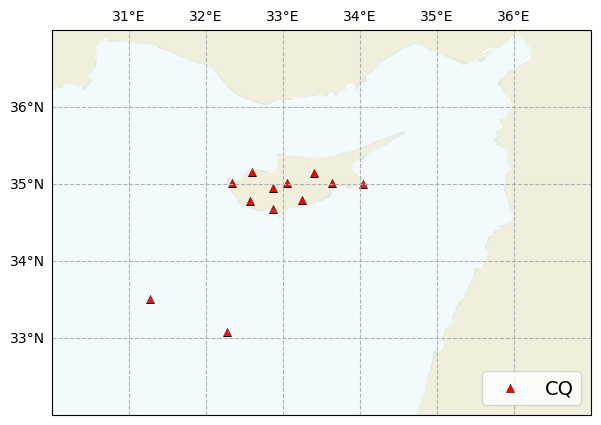

In [11]:
plot_station_map(figsize=(12,5), extent1=[30,37, 32,37])

## Set up our thought experiment

In [12]:
# Evaluate EQs on a grid
X = np.arange(30., 37., 0.1) # longitude in 0.1 deg steps
Y = np.arange(32, 37, 0.1) # latitude in 0.1 deg steps
Z = np.arange(5,100,2) # depth in 2 km steps
xx, yy, zz = np.meshgrid(X,Y,Z)
print(xx.shape, yy.shape, zz.shape)

(50, 70, 48) (50, 70, 48) (50, 70, 48)


In [13]:
vp = 6 # km/s, reasonable estimate for Vp
vs = 4 # km/s reasonable Vs estimate

In [14]:
# Flatten the grid
lons_eq = xx.flatten()
lats_eq = yy.flatten()
depths_eq = zz.flatten()

Text(0.5, 1.0, 'Suite of test EQ epicenters \n Depth slice at 5km')

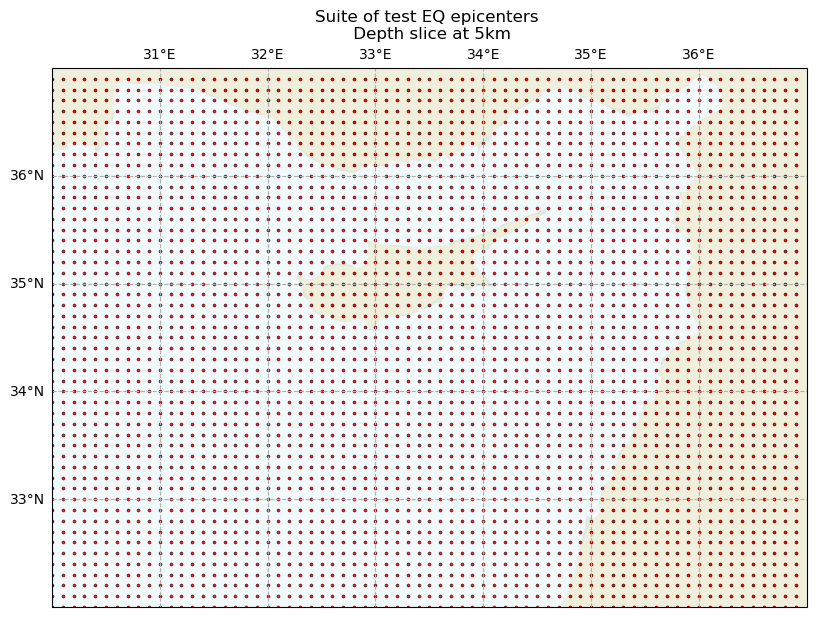

In [15]:
extent1=[30,37, 32,37]
x1, x2, y1, y2 = extent1
fig = plt.figure(figsize=(12,7))

# Extract data for plotting
# Plot only the first depth slice
idx = np.where(depths_eq == depths_eq[0])

lons_plot = lons_eq[idx]
lats_plot = lats_eq[idx]

ax2 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), extent=extent1)



ax2.add_feature(cft.LAND) # add the land polygons
ax2.add_feature(ocean_50m)

# Plot stations
# Plot OBS - supply arrays of lon, lat
ax2.scatter(lons_plot, lats_plot,
 marker='o', ec='k', c="red", lw=0.3, s=5)

ax2.ticklabel_format(useOffset=False)
gl = ax2.gridlines(draw_labels=True, linestyle="--")
gl.bottom_labels = False; gl.right_labels = False
ax2.set_title(f'Suite of test EQ epicenters \n Depth slice at {depths_eq[0]}km')


# for stat in BK_df.itertuples():
#     if stat.lat > y1 and stat.lat < y2 and stat.lon > x1 and stat.lon < x2: 
#         ax1.text(stat.lon, stat.lat, stat.code, color='black', fontsize='small', 
#                 va='top', ha='center',rotation='horizontal', 
#                 transform=ccrs.PlateCarree(), 
#                 bbox={'facecolor': 'white', 'alpha': 0.4, 'pad': 1})


In [16]:
# Extract station info
stla = inv_df['lat'].values
stlo = inv_df['lon'].values
stele = inv_df['elev_km'].values

In [17]:
# Loop over stations and compute first break arrival times for all EQ on grid
# Work on a per station basis
from pyproj import Geod
g = Geod(ellps='WGS84')
# Store arr times for each stat
sta_arr = []

for lon, lat, elev in list(zip(stlo, stla, stele)):
    # Compute trigger times
    sta_lons = len(lons_eq)*[lon]
    sta_lats = len(lons_eq)*[lat]
    sta_elev = len(lons_eq)*[elev]
    sta_elev = np.array(sta_elev)
    # Compute distances
    az12,az21,dist = g.inv(sta_lons,sta_lats,lons_eq,lats_eq)
    dist = np.array(dist)/1000 # horiz distances in km
    hyp_dist = np.sqrt(dist**2 + (depths_eq - sta_elev)**2)
    arr_times = hyp_dist/vp # Est P wave arr time
    sta_arr.append(arr_times)

In [18]:
nicosia_lon = 33.3650
nicosia_lat = 35.1725
# Also compute S-wave arrival times for the center of Nicosia
nicosia_lons = np.full(len(lons_eq), fill_value=nicosia_lon)
nicosia_lats = np.full(len(lons_eq), fill_value=nicosia_lat)
nicosia_elev = np.full(len(lons_eq), fill_value=0.0)
# Compute distances
az12,az21,dist = g.inv(nicosia_lons,nicosia_lats,lons_eq,lats_eq)
dist = np.array(dist)/1000 # horiz distances in km
hyp_dist = np.sqrt(dist**2 + (depths_eq - nicosia_elev)**2)
nicosia_s_times = hyp_dist/vs # Est P wave arr time

In [19]:
sta_arr = np.array(sta_arr)

In [20]:
sorted_times = np.sort(sta_arr, axis=0)

# Extract system response times
Network-based EEW algorithms like EPIC, operate using triggers from a number of stations in a network. Let's assume a network algorithm can alert for an event once 4 stations have triggered (current ShakeAlert protocol), and we'll also take the more optimistic case of 2-station alerting (like m-EPIC).

In [21]:
# Extract 2-station and 4-station times
two_station = sorted_times[1, :]
four_station = sorted_times[3, :]


# Also compute warning times for Nicosia city center
# Assume no latency
alerttime_4station = nicosia_s_times - four_station
alerttime_2station = nicosia_s_times - two_station

In [22]:
alerttime_4station.argmin()

109152

Text(0.5, 1.0, 'System Alert Issuance Times wrt EQ location \n  4-station alerting \n Depth slice at 5km')

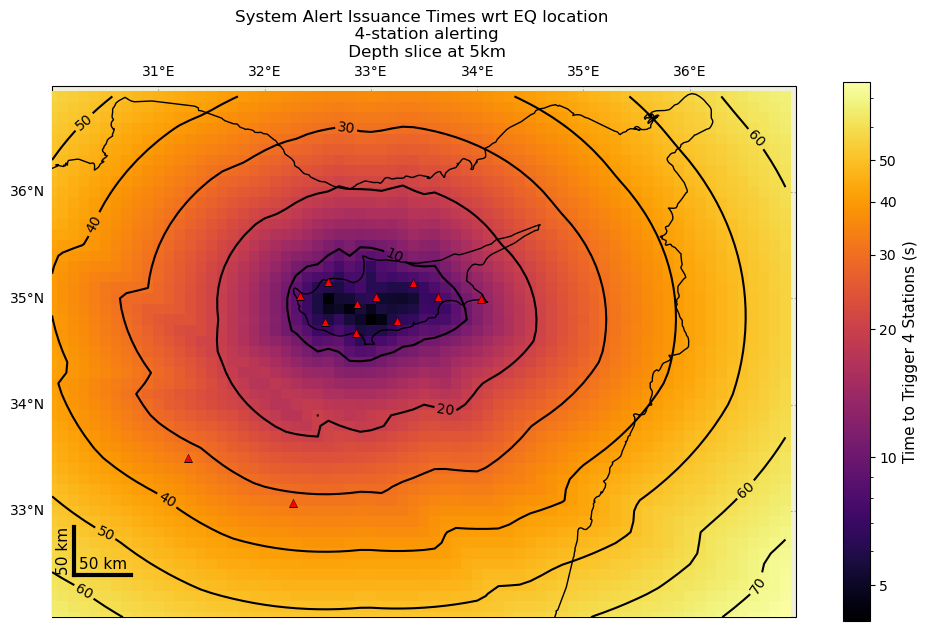

In [23]:
# Plot a mesh of alert issuance times, 4 stations
extent1=[30,37, 32,37]
x1, x2, y1, y2 = extent1
fig = plt.figure(figsize=(12,7))

# Extract data for plotting
# Plot only the first depth slice
idx = np.where(depths_eq == depths_eq[0])

lons_plot = lons_eq[idx].reshape(xx.shape[0], xx.shape[1])
lats_plot = lats_eq[idx].reshape(xx.shape[0], xx.shape[1])
four_station_to_plot = four_station[idx].reshape(xx.shape[0], xx.shape[1])

# four_station_to_plot = four_station_to_plot.reshape(xx.shape[0], xx.shape[1])
# Set up plotting
ax2 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), extent=extent1)


ax2.add_feature(cft.LAND) # add the land polygons
ax2.add_feature(ocean_50m)
ax2.coastlines(zorder=20)

# Plot stations
ax2.scatter(inv_df.lon, inv_df.lat,
     marker='^', ec='k', c="red", lw=0.3, zorder=21)


# Color grid
c = ax2.pcolormesh(lons_plot, lats_plot, four_station_to_plot,
                   shading='auto',
                  norm=LogNorm(vmin=four_station_to_plot.min(), 
                                vmax=four_station_to_plot.max()), 
                  cmap='inferno', zorder=10)

# Contours
CS = ax2.contour(lons_plot, lats_plot, four_station_to_plot, 
                 zorder=11, colors='k')

ax2.clabel(CS, CS.levels, inline=True, fontsize=10, colors='k')

# Cbar formatting
cbar = fig.colorbar(c, ax=ax2)
cbar.ax.set_yticks([5, 10, 20, 30, 40,50])

cbar.ax.set_yticklabels(labels=[5, 10, 20, 30, 40,50],
                        color="k", size=9)

cbar.set_label(label='Time to Trigger 4 Stations (s)', fontsize=11)
cbar.ax.tick_params(axis="both", labelsize=10)

# Add scale bars
# Add scale bar to main panel
scale_bar(ax2, (0.03, 0.08), 50, angle=0, fontsize=11, zorder=11)
scale_bar(ax2, (0.03, 0.08), 50, angle=90, fontsize=11, zorder=11)

ax2.ticklabel_format(useOffset=False)
gl = ax2.gridlines(draw_labels=True, linestyle="--")
gl.bottom_labels = False; gl.right_labels = False
ax2.set_title(f'System Alert Issuance Times wrt EQ location \n  4-station alerting \n Depth slice at {depths_eq[0]}km')


# for stat in BK_df.itertuples():
#     if stat.lat > y1 and stat.lat < y2 and stat.lon > x1 and stat.lon < x2: 
#         ax1.text(stat.lon, stat.lat, stat.code, color='black', fontsize='small', 
#                 va='top', ha='center',rotation='horizontal', 
#                 transform=ccrs.PlateCarree(), 
#                 bbox={'facecolor': 'white', 'alpha': 0.4, 'pad': 1})


Text(0.5, 1.0, 'System Alert Issuance Times wrt EQ location \n  2-station alerting \n Depth slice at 5km')

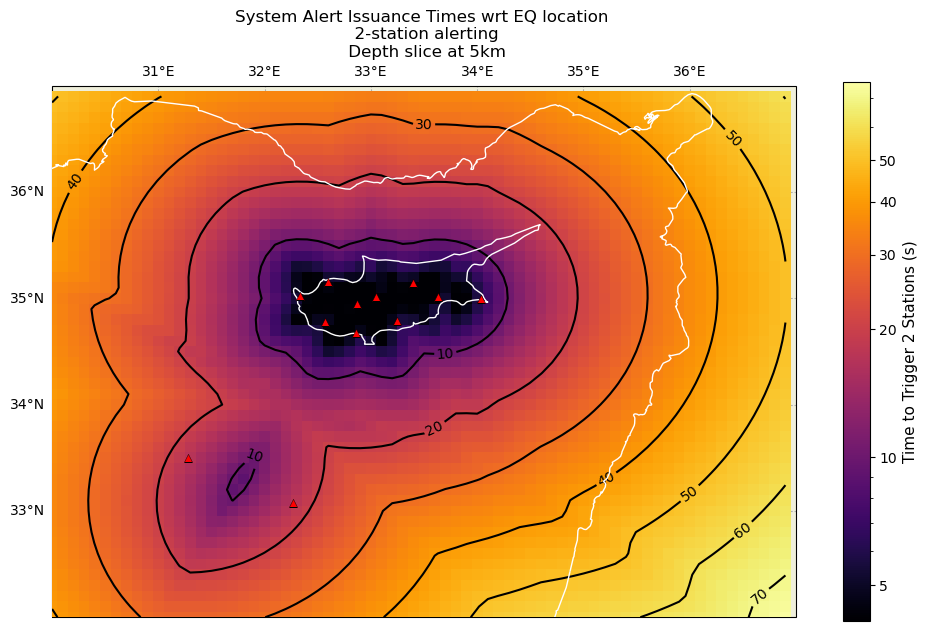

In [24]:
# Plot a mesh of alert issuance times, 4 stations
extent1=[30,37, 32,37]
x1, x2, y1, y2 = extent1
fig = plt.figure(figsize=(12,7))

# Extract data for plotting
# Plot only the first depth slice
idx = np.where(depths_eq == depths_eq[0])

lons_plot = lons_eq[idx].reshape(xx.shape[0], xx.shape[1])
lats_plot = lats_eq[idx].reshape(xx.shape[0], xx.shape[1])
two_station_to_plot = two_station[idx].reshape(xx.shape[0], xx.shape[1])

# four_station_to_plot = four_station_to_plot.reshape(xx.shape[0], xx.shape[1])
# Set up plotting
ax2 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), extent=extent1)


ax2.add_feature(cft.LAND) # add the land polygons
ax2.add_feature(ocean_50m)
ax2.coastlines(zorder=20, color='white')

# Plot stations
ax2.scatter(inv_df.lon, inv_df.lat,
     marker='^', ec='k', c="red", lw=0.3, zorder=21)


# Color grid
c = ax2.pcolormesh(lons_plot, lats_plot, two_station_to_plot,
                   shading='auto',
                  norm=LogNorm(vmin=four_station_to_plot.min(), 
                                vmax=four_station_to_plot.max()), 
                  cmap='inferno', zorder=10)

# Contours
CS = ax2.contour(lons_plot, lats_plot, two_station_to_plot, 
                 zorder=11, colors='k')

ax2.clabel(CS, CS.levels, inline=True, fontsize=10, colors='k')

# Cbar formatting
cbar = fig.colorbar(c, ax=ax2)
cbar.ax.set_yticks([5, 10, 20, 30, 40,50])

cbar.ax.set_yticklabels(labels=[5, 10, 20, 30, 40,50],
                        color="k", size=9)

cbar.set_label(label='Time to Trigger 2 Stations (s)', fontsize=11)
cbar.ax.tick_params(axis="both", labelsize=10)

ax2.ticklabel_format(useOffset=False)
gl = ax2.gridlines(draw_labels=True, linestyle="--")
gl.bottom_labels = False; gl.right_labels = False
ax2.set_title(f'System Alert Issuance Times wrt EQ location \n  2-station alerting \n Depth slice at {depths_eq[0]}km')


# for stat in BK_df.itertuples():
#     if stat.lat > y1 and stat.lat < y2 and stat.lon > x1 and stat.lon < x2: 
#         ax1.text(stat.lon, stat.lat, stat.code, color='black', fontsize='small', 
#                 va='top', ha='center',rotation='horizontal', 
#                 transform=ccrs.PlateCarree(), 
#                 bbox={'facecolor': 'white', 'alpha': 0.4, 'pad': 1})


5
-6.369132755266396 51.20616512888731


Text(0.5, 1.0, 'Warning Times (time alert issued before S-wave) for Nicosia City Center wrt EQ location \n  4-station alerting \n Depth slice at 5km')

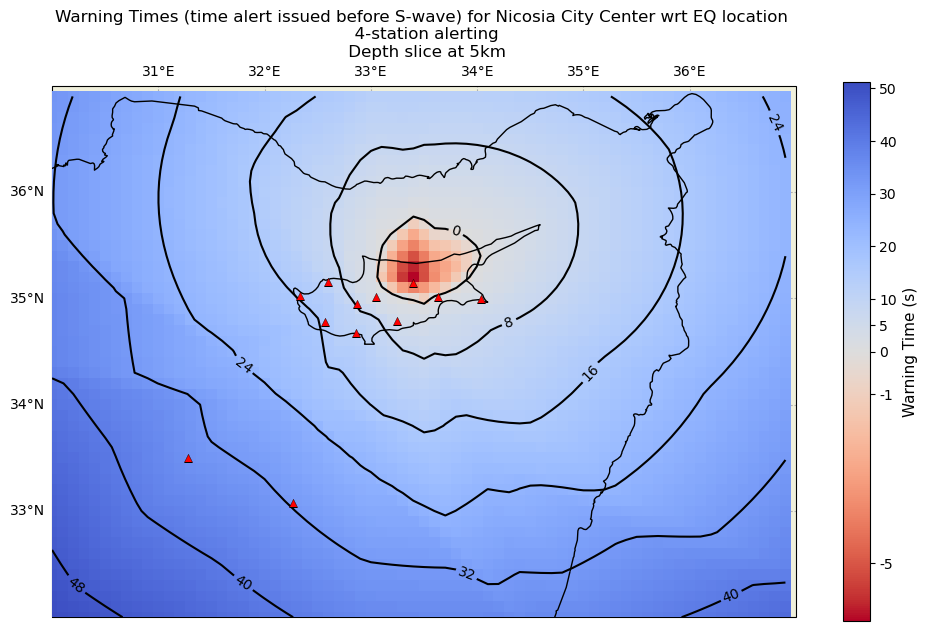

In [25]:
# Warning times for Nicosia city center
# Plot a mesh of alert issuance times
extent1=[30,37, 32,37]
x1, x2, y1, y2 = extent1
fig = plt.figure(figsize=(12,7))

# Extract data for plotting
# Plot only the first depth slice
idx = np.where(depths_eq == depths_eq[0])
print(depths_eq[0])

lons_plot = lons_eq[idx].reshape(xx.shape[0], xx.shape[1])
lats_plot = lats_eq[idx].reshape(xx.shape[0], xx.shape[1])
alerttimes_to_plot = alerttime_4station[idx].reshape(xx.shape[0], xx.shape[1])
print(alerttimes_to_plot .min(), alerttimes_to_plot .max())

# four_station_to_plot = four_station_to_plot.reshape(xx.shape[0], xx.shape[1])
# Set up plotting
ax2 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), extent=extent1)


ax2.add_feature(cft.LAND) # add the land polygons
ax2.add_feature(ocean_50m)
ax2.coastlines(zorder=20)

# Plot stations
ax2.scatter(inv_df.lon, inv_df.lat,
     marker='^', ec='k', c="red", lw=0.3, zorder=21)


# Color grid
c = ax2.pcolormesh(lons_plot, lats_plot, alerttimes_to_plot,
                   shading='auto',
                  norm=TwoSlopeNorm(vmin=alerttimes_to_plot.min(), 
                                vmax=alerttimes_to_plot.max(),
                                   vcenter=0.0), 
                  cmap='coolwarm_r', zorder=10)

# Contours
CS = ax2.contour(lons_plot, lats_plot, alerttimes_to_plot, 
                 zorder=11, colors='k')

ax2.clabel(CS, CS.levels, inline=True, fontsize=10, colors='k')

# Cbar formatting
cbar = fig.colorbar(c, ax=ax2)
cbar.ax.set_yticks([-5, -1, 0, 5, 10, 20, 30, 40,50])

cbar.ax.set_yticklabels(labels=[-5, -1, 0, 5, 10, 20, 30, 40,50],
                        color="k", size=9)

cbar.set_label(label='Warning Time (s)', fontsize=11)
cbar.ax.tick_params(axis="both", labelsize=10)

ax2.ticklabel_format(useOffset=False)
gl = ax2.gridlines(draw_labels=True, linestyle="--")
gl.bottom_labels = False; gl.right_labels = False
ax2.set_title(f'Warning Times (time alert issued before S-wave) for Nicosia City Center wrt EQ location \n  4-station alerting \n Depth slice at {depths_eq[0]}km')


# for stat in BK_df.itertuples():
#     if stat.lat > y1 and stat.lat < y2 and stat.lon > x1 and stat.lon < x2: 
#         ax1.text(stat.lon, stat.lat, stat.code, color='black', fontsize='small', 
#                 va='top', ha='center',rotation='horizontal', 
#                 transform=ccrs.PlateCarree(), 
#                 bbox={'facecolor': 'white', 'alpha': 0.4, 'pad': 1})


The map above makes full sense - a shallow ($z=5\,km$) event right underneath Nicosia would lead to strongly negative alert times for the city center. What is striking is that events all along the length of the unstudied Ovgos Fault would also cause negative alert times, as would any events to the north, due to the lack of stations. Nicosia would get $\sim 20\,s$ of warning for a shallow event offshore Paphos (whether 1996 or Jan 2022-like).

Key question here is - what difference would it make if we added in the Turkish accelerometric network (TK) and the Kandilli Observatory (KO) stations?

We model what how the network would fare in specific scenarios in the next section.

### Adding in stations outside the CQ network

### Extension: Dropping stations
What happens to our warning times if we start dropping stations (e.g., to simulate bad triggers/stations not reporting/comms outages)?

Let's do this by bootstrapping - removing one station at a time

## Scenario-based EEW
Here we attempt the reverse problem: if we know where we have our earthquake locations, can we estimate warning times on a grid?

We model all earthquakes as point sources, and assume constant $V_P$ and $V_S$

Scenarios to model: Paphos 1996 ($M_w \,6.8$), Paphos 1953 ($M_w \,6.3$), Paphos 1995 ($M_w \,5.9$), Florence Arc 2022 ($M_w \,6.6$), Limassol 1999 ($M_w \,5.6$), Antakya 2023 ($M_w \,6.3$)

For more EQ, look at Papadimitriou and Karakostas [(2006)](https://doi.org/10.1016/j.tecto.2006.03.014)

### Step 1: Function to model the trigger times

### Step 2: Use Cua-Heaton envelope methods to predict ShakeMap
Use the method from Diego Melgar on GitHub https://github.com/dmelgarm/gmpe_tools/blob/master/simulating_shakemaps_and_seismograms.ipynb

We will still need an appropriate GMM:
- There is no non-ergodic model specifically applicable to Cyprus due to a lack of data (few earthquakes) and stations to get dense strong motion records
- Let's use the Akkar, Sandikkaya, and Bommer [(2014)](https://doi.org/10.1007/s10518-013-9461-4) model (developed for Europe and the Middle East), implemented in `pygmm` for the GMM part

### Step 3: Combine into an alerttime contour map

Use prototype plotting scheme from BSL-MyShake to overlay ShakeMap w/alerttime contours